# NETWORK QUALITY EVALUATION PLOTS

## Comparison: Tissue-specific METANets vs Tissue-specific PANDA (26 tissues)
- Binding
- GO
- GO-directness
- PPI

### (i) imports, parameters, and functions

In [6]:
import pandas as pd
import numpy as np
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects
import matplotlib.ticker as ticker
import seaborn as sns
import argparse
import os
from scipy.stats import ttest_rel, ttest_ind, ttest_1samp
from matplotlib.lines import Line2D
from itertools import combinations, permutations

#####################
# pyplot parameters #
#####################
plt.rcParams['axes.labelsize'] = 'xx-large'
plt.rcParams['xtick.labelsize'] = 'x-large'
plt.rcParams['ytick.labelsize'] = 'x-large'
plt.rcParams['legend.fontsize'] = 'xx-large'
plt.rcParams['axes.titlesize'] = '20'

# MODEL PLOTTING COLOR SCHEME #
model_palette = {
    'tissue-specific METANet':'tab:pink',
    'tissue-specific PANDA':'tab:cyan',
    'random permutation':'tab:gray',
    'random':'k'
}
medianprops = {
    'color':'tab:red',
    'ls': ':',
    'lw': 2
}

#################
### arguments ###
#################
parser = argparse.ArgumentParser(description="creates boxplot of evaluation results across tissues")
parser.add_argument("--results_path", default="/scratch/mblab/jungw/human_TF_project/data/xgboost_all_gtex_tissues/results/", help="results path")
parser.add_argument("--features_path", default="/scratch/mblab/jungw/human_TF_project/data/xgboost_all_gtex_tissues/input_data/", help="features path")
parser.add_argument("--binding_threshold", default=10, type=int, help="binding threshold (default=5)")
### TISSUES HAVE UPDATED TO ONLY INCLUDE 26 TISSUES IN COMMON WITH SONAWANE ET AL 2017 PANDA NETWORKS
parser.add_argument("--tissues", default="/scratch/mblab/jungw/human_TF_project/data/xgboost_all_gtex_tissues/tissues_panda_metanet_overlap.txt", help="list of tissues to include in plot")
parser.add_argument("--ppi_db_path", default="/scratch/mblab/jungw/NET-evaluation/metadata/human/9606.STRING.gencodev29_ENSG_700.txt", help="path to ppi db")
parser.add_argument("--plot_random", default=True, action='store_true', help="use to plot random and random expectation")
parser.add_argument("--output_path", default="/scratch/mblab/jungw/human_TF_project/manuscript_figures/network_quality/", help="output path to save plots")
args = parser.parse_args(args=[])

###############################
### MODEL NAMING PARAMETERS ###
###############################
# Tissue-specific METANet
models_metanet_tissue_specific = {
    'xgboost_specific':'tissue-specific METANet',
}
# Sonawane et al 2017 tissue-specific PANDA networks
models_panda_tissue_specific = {
    'panda_tissue_specific':'tissue-specific PANDA'
}

In [2]:
#################
### FUNCTIONS ###
#################
def load_binding(model, path, modelname):

    df = pd.read_csv(
        os.path.join(path, f"eval_binding_{model}.tsv"),
        sep = "\t", header=None,
        names=['rank','score']
    )
    df['model'] = modelname
    return df

def load_ppi(model, path, modelname):

    if model=='xgboost_subset':
        model= 'xgboost'

    df = pd.read_csv(
        os.path.join(path, f"eval_ppi_{model}.tsv"),
        sep = "\t"
    )
    df['model'] = modelname
    return df

def load_go(model, path, modelname):

    if model=='xgboost_subset':
        model= 'xgboost'

    df_go_directness = pd.read_csv(
        os.path.join(path, f"go250_{model}_nopenalty", f"eval_go250_directness_{model}.tsv"),
        sep=",", na_values='na',
        header=None, names=['rank','score']
    )
    df_go_directness['model'] = modelname

    df_go = pd.read_csv(
        os.path.join(path, f"go250_{model}_nopenalty", f"eval_go250_{model}.tsv"),
        sep="\t", na_values='na',
    )
    df_go['rank'] = df_go_directness['rank']
    df_go['model'] = modelname

    return df_go, df_go_directness

def load_binding_permutations(results_path, tissues, features="METANet", model="xgboost", n_permutations=50):

    df_binding_permutations_list = []

    for tissue in tissues:
        eval_path = os.path.join(
            results_path, tissue, features, model, "evaluation"
        )
        for i in range(n_permutations):
            idx = i+1
            df_binding_permutation = pd.read_csv(
                os.path.join(eval_path, f"go250_{model}_nopenalty_edge_permutations", f"{tissue}_{model}_stableID_permutation{idx}_nopenalty",
                             f"eval_binding_permutation{idx}.tsv"),
                sep = "\t", header=None,
                names=['rank','score']
            )
            df_binding_permutation['model'] = 'random permutation'
            df_binding_permutation['tissue'] = tissue
            df_binding_permutation['permutation'] = idx

            df_binding_permutations_list.append(df_binding_permutation)
    
    df_binding_permutations = pd.concat(df_binding_permutations_list)

    return df_binding_permutations

def load_ppi_permutations(results_path, tissues, features="METANet", model='xgboost', n_permutations=50):

    df_ppi_permutations_list = []

    for tissue in tissues:
        eval_path = os.path.join(
            results_path, tissue, features, model, "evaluation"
        )
        for i in range(n_permutations):
            idx = i+1
            df_ppi_permutation = pd.read_csv(
                os.path.join(eval_path, f"go250_{model}_nopenalty_edge_permutations", f"{tissue}_{model}_stableID_permutation{idx}_nopenalty",
                             f"eval_ppi_permutation{idx}.tsv"),
                sep = "\t"
            )
            df_ppi_permutation['model'] = 'random permutation'
            df_ppi_permutation['tissue'] = tissue
            df_ppi_permutation['permutation'] = idx

            df_ppi_permutations_list.append(df_ppi_permutation)
    
    df_ppi_permutations = pd.concat(df_ppi_permutations_list)

    return df_ppi_permutations
        

def load_go_permutations(results_path, tissues, features="METANet", model='xgboost', n_permutations=50):

    df_go_permutations_list = []
    df_go_directness_permutations_list = []

    for tissue in tissues:
        eval_path = os.path.join(
            args.results_path, tissue, features, model, "evaluation"
        )

        for i in range(n_permutations):
            idx = i+1
            df_go_directness_permutation = pd.read_csv(
                os.path.join(eval_path, f"go250_{model}_nopenalty_edge_permutations", f"{tissue}_{model}_stableID_permutation{idx}_nopenalty", f"eval_go250_directness_{model}_permutation{idx}.tsv"),
                sep=",", na_values='na',
                header=None, names=['rank','score']
            )
            df_go_directness_permutation['tissue'] = tissue
            df_go_directness_permutation['model'] = 'random permutation'
            df_go_directness_permutation['permutation'] = idx


            df_go_permutation = pd.read_csv(
                os.path.join(eval_path, f"go250_{model}_nopenalty_edge_permutations", f"{tissue}_{model}_stableID_permutation{idx}_nopenalty", f"eval_go250_{model}_permutation{idx}.tsv"),
                sep="\t", na_values='na',
            )
            df_go_permutation['rank'] = df_go_directness_permutation['rank']
            df_go_permutation['tissue'] = tissue
            df_go_permutation['model'] = 'random permutation'
            df_go_permutation['permutation'] = idx

            df_go_permutations_list.append(df_go_permutation)
            df_go_directness_permutations_list.append(df_go_directness_permutation)

    df_go_permutations = pd.concat(df_go_permutations_list)
    df_go_directness_permutations = pd.concat(df_go_directness_permutations_list)

    # drop NA
    df_go_permutations = df_go_permutations.dropna()
    df_go_directness_permutations = df_go_directness_permutations.dropna()

    return df_go_permutations, df_go_directness_permutations



def calculate_binding_random_expectation(features_path, tissues, features="METANet"):

    list_ratio_positive = []
    for tissue in tissues:
        feature_tissue_path = os.path.join(args.features_path, tissue, features)
        df = pd.read_csv(
            os.path.join(
                feature_tissue_path,
                f"{tissue}_{features}.txt"
            ),
            sep="\t"
        )
        ratio_positive = df['LABEL'].sum() / len(df)
        list_ratio_positive.append(ratio_positive)
    avg_ratio = np.mean(list_ratio_positive) * 100 # as percentage

    return avg_ratio

def calculate_ppi_random_expectation(results_path, tissues, df_ppi, features="METANet", model="xgboost"):

    df_ppi['protein1'] = df_ppi['protein1'].str.split('.', expand=True)[0]
    df_ppi['protein2'] = df_ppi['protein2'].str.split('.', expand=True)[0]
    df_ppi = df_ppi[df_ppi['combined_score'] >= 700]
    df_ppi['tf_tf_pair'] = df_ppi['protein1'].astype(str) + '-' + df_ppi['protein2'].astype(str)
    ppi_tf_tf_pairs = set(df_ppi['tf_tf_pair'].unique())

    ppi_expectation_list = []
    for tissue in tissues:
        tissue_path = os.path.join(results_path, tissue, features)
        df = pd.read_csv(os.path.join(tissue_path, model, f"{tissue}_{model}_stableID.tsv"),
                        sep="\t", header=None, names=['TF','GENE','SCORE'])
        tfs_unique = df['TF'].unique()
        tf_tf_pairs = list(combinations(tfs_unique, 2))
        df_tf_pairs = pd.DataFrame(tf_tf_pairs, columns=['TF1','TF2'])
        df_tf_pairs['tf_tf_pair'] = df_tf_pairs['TF1'].astype(str) + '-' + df_tf_pairs['TF2'].astype(str)
        tf_tf_pairs = set(df_tf_pairs['tf_tf_pair'].unique())
        ppi_expectation = len(ppi_tf_tf_pairs.intersection(tf_tf_pairs)) / len(tf_tf_pairs)
        ppi_expectation_list.append(ppi_expectation)
        
    mean_ppi_expectation = np.mean(ppi_expectation_list) * 100 # as percentage

    return mean_ppi_expectation

def add_median_labels(ax: plt.Axes, fmt: str = ".1f") -> None:
    """Add text labels to the median lines of a seaborn boxplot.

    Args:
        ax: plt.Axes, e.g. the return value of sns.boxplot()
        fmt: format string for the median value
    """
    lines = ax.get_lines()
    boxes = [c for c in ax.get_children() if "Patch" in str(c)]
    start = 4
    if not boxes:  # seaborn v0.13 => fill=False => no patches => +1 line
        boxes = [c for c in ax.get_lines() if len(c.get_xdata()) == 5]
        start += 1
    lines_per_box = len(lines) // len(boxes)
    for median in lines[start::lines_per_box]:
        x, y = (data.mean() for data in median.get_data())
        # choose value depending on horizontal or vertical plot orientation
        value = x if len(set(median.get_xdata())) == 1 else y
        text = ax.text(x, y, f'{value:{fmt}}', ha='center', va='center',
                       fontweight='bold', color='white', fontsize='large', zorder=200)
        # create median-colored border around white text for contrast
        text.set_path_effects([
            path_effects.Stroke(linewidth=3, foreground=median.get_color()),
            path_effects.Normal(),
        ])

## t-test between each pair of models ##
def ttest_per_rank(df, score_col):

    # rename score_col to score
    df = df.rename(columns={score_col:"score"})

    # sort by tissue
    df = df.sort_values(by=['tissue','model'])

    # pairs of models
    models = df['model'].unique()
    pairs = list(permutations(models, 2))
    ttest_results = {}

    for rank in df['rank'].unique():
        subset = df[df['rank'] == rank]
        for model1, model2 in pairs:
            score_model1 = subset[subset['model'] == model1].sort_values(by='tissue')['score']
            score_model2 = subset[subset['model'] == model2].sort_values(by='tissue')['score']
            if model1 == 'random permutation' or model2 == 'random permutation':
                t_stat, pval = ttest_ind(score_model1, score_model2)
            else:
                t_stat, pval = ttest_rel(score_model1, score_model2)
            ttest_results[(rank, model1, model2)] = pval

    return ttest_results

import matplotlib.pyplot as plt
from itertools import combinations

def add_significance_bars_modified(ax, rank_pval_dict, df_data, models_to_plot, score_col='score', max_y=None):
   
    def pval_to_annt(p):
        if p < 0.001:
            return '***'
        elif p < 0.01:
            return '**'
        elif p < 0.05:
            return '*'
        else:
            return 'ns'

    # figure out models to plot
    models_to_plot = [model for model in models_to_plot if model in df_data['model'].unique()]
    num_models = len(models_to_plot)

    # find ranks
    ranks = df_data['rank'].unique().tolist()
    y_max = df_data[score_col].max()
    if max_y is not None and y_max > max_y:
        y_max = max_y
    small_y = y_max < 16
    
    for i, rank in enumerate(ranks):

        dict_x_positions = {}
        # get base y position
        y_gap = y_max * 0.03
        if small_y:
            y_gap = y_max * 0.05
        y_base = df_data[df_data['rank'] == rank][score_col].max()
        if max_y is not None and y_base > max_y:
            y_base = max_y + 0.5
        y_base = y_base + y_gap

        for j, model in enumerate(models_to_plot):
            
            # get x positions of each model boxplot
            if num_models % 2 == 0:
                dict_x_positions[model] = i + (-0.3) + (0.2 * j)
            else:
                dict_x_positions[model] = i + (-0.25 * ((num_models-1)/2)) + (0.25 * j)
            # y offset between each sig bar
            y_offset = y_max * 0.03
            if small_y:
                y_offset = y_max * 0.02

        model_pair = combinations(models_to_plot, 2)
        for p, (model1, model2) in enumerate(model_pair):
            # print(model1, model2)

            # plot only if significant
            pval = rank_pval_dict[(rank,model1,model2)]
            if pval > 0.05:
                continue
            if model1 != 'METANet':
                continue
            pval_annt = pval_to_annt(pval)

            x1 = dict_x_positions[model1]
            x2 = dict_x_positions[model2]
            x_text = (x1+x2) / 2
            y1 = y_base + (y_offset * p)
            y2 = y_base + (y_offset * (p+1))
            y_base = y_base + y_gap

            ax.plot([x1, x1, x2, x2], [y1, y2, y2, y1], lw=0.5, c='black', zorder=200)
            ax.text(x_text, y2, pval_annt, ha='center', va='center', fontsize=5, zorder=201)

### (ii) load data

#### load random

In [4]:
# load tissues
all_tissues = np.loadtxt(args.tissues, dtype=str)
print(f" - found {len(all_tissues)} tissues")

if args.plot_random:
    # calculate binding expectation
    print("calculating binding random expectation")
    binding_random_expectation = calculate_binding_random_expectation(args.features_path, all_tissues, features="METANet")
    print(binding_random_expectation)

    # calculate ppi expectation
    # load ppi db
    print("calculating ppi random expectation")
    df_ppi = pd.read_csv(args.ppi_db_path, sep=" ")
    ppi_random_expectation = calculate_ppi_random_expectation(args.results_path, all_tissues, df_ppi, features="METANet", model="xgboost")
    print(ppi_random_expectation)
    del df_ppi

 - found 26 tissues
calculating binding random expectation
8.684679994135022
calculating ppi random expectation
3.201009032836233


#### load evaluation results

In [8]:
print("load eval results")
df_binding_list = []
df_go_directness_list = []
df_go_list = []
df_ppi_list = []

for tissue in all_tissues:
    print(tissue)
    tissue_metanet_specific_path = os.path.join(args.results_path, tissue, "METANet")
    tissue_panda_specific_path = os.path.join(args.results_path, tissue, "benchmark_networks")

    df_binding_model_list = []
    df_go_model_list = []
    df_go_directness_model_list = []
    df_ppi_model_list = []

    ## METANet ##
    for model in models_metanet_tissue_specific.keys():
        model_path = os.path.join(tissue_metanet_specific_path, model, 'evaluation')

        # load binding
        df_binding = load_binding(model, model_path, models_metanet_tissue_specific[model])

        # load ppi
        df_ppi = load_ppi(model, model_path, models_metanet_tissue_specific[model])

        # load go and go-directness
        df_go, df_go_directness = load_go(model, model_path, models_metanet_tissue_specific[model])

        # append to lists
        df_binding_model_list.append(df_binding)
        df_ppi_model_list.append(df_ppi)
        df_go_model_list.append(df_go)
        df_go_directness_model_list.append(df_go_directness)
    
    ## SONAWANE ET AL 2017 PANDA NETWORKS ##
    for model in models_panda_tissue_specific.keys():
        model_path = os.path.join(tissue_panda_specific_path, model, 'evaluation')

        # load binding
        df_binding = load_binding(model, model_path, models_panda_tissue_specific[model])

        # load ppi
        df_ppi = load_ppi(model, model_path, models_panda_tissue_specific[model])

        # load go and go-directness
        df_go, df_go_directness = load_go(model, model_path, models_panda_tissue_specific[model])

        # append to lists
        df_binding_model_list.append(df_binding)
        df_ppi_model_list.append(df_ppi)
        df_go_model_list.append(df_go)
        df_go_directness_model_list.append(df_go_directness)


    df_binding_tissue = pd.concat(df_binding_model_list)
    df_binding_tissue['tissue'] = tissue
    df_binding_list.append(df_binding_tissue)

    df_go_directness_tissue = pd.concat(df_go_directness_model_list)
    df_go_directness_tissue['tissue'] = tissue
    df_go_directness_list.append(df_go_directness_tissue)

    df_go_tissue = pd.concat(df_go_model_list)
    df_go_tissue['tissue'] = tissue
    df_go_list.append(df_go_tissue)

    df_ppi_tissue = pd.concat(df_ppi_model_list)
    df_ppi_tissue['tissue'] = tissue
    df_ppi_list.append(df_ppi_tissue)


load eval results
adipose_subcutaneous
adipose_visceral_omentum
artery_aorta
artery_coronary
artery_tibial
brain_cerebellum
breast_mammary_tissue
colon_transverse
esophagus_mucosa
esophagus_muscularis
heart_left_ventricle
liver
lung
muscle_skeletal
nerve_tibial
ovary
pancreas
pituitary
prostate
spleen
stomach
testis
thyroid
uterus
vagina
whole_blood


### (iii) evaluation result processing

#### subset for avg targets/TF thresholds

In [9]:
# concat
df_binding = pd.concat(df_binding_list)
df_go = pd.concat(df_go_list)
df_go_directness = pd.concat(df_go_directness_list)
df_ppi = pd.concat(df_ppi_list)

# subset for specific thresholds
subset_ranks = ['full']
subset_ranks_ppi = [50,100]
df_binding = df_binding[df_binding['rank'].isin(subset_ranks)]
df_go = df_go[df_go['rank'].isin(subset_ranks)]
df_go_directness = df_go_directness[df_go_directness['rank'].isin(subset_ranks)]
df_ppi = df_ppi[df_ppi['rank'].isin(subset_ranks_ppi)]

df_binding = df_binding.sort_values(by=['model','tissue'])

#### t-test between models for matching tissues

In [10]:
dict_binding_ttest = ttest_per_rank(df_binding, score_col="score")
dict_ppi_ttest = ttest_per_rank(df_ppi, score_col="ppi_support")
dict_go_ttest = ttest_per_rank(df_go, score_col="median")
dict_go_directness_ttest = ttest_per_rank(df_go_directness, score_col="score")

In [11]:
### MODELS TO PLOT ###
models_to_plot = ['tissue-specific METANet','tissue-specific PANDA']

In [12]:
df_binding_final = df_binding[df_binding['model'].isin(models_to_plot + ['random_permutation','random'])]
df_go_final = df_go[df_go['model'].isin(models_to_plot + ['random_permutation','random'])]
df_go_directness_final = df_go_directness[df_go_directness['model'].isin(models_to_plot + ['random_permutation','random'])]
df_ppi_final = df_ppi[df_ppi['model'].isin(models_to_plot + ['random_permutation','random'])]

dict_binding_ttest_final = ttest_per_rank(df_binding_final, score_col="score")
dict_ppi_ttest_final = ttest_per_rank(df_ppi_final, score_col="ppi_support")
dict_go_ttest_final = ttest_per_rank(df_go_final, score_col="median")
dict_go_directness_ttest_final = ttest_per_rank(df_go_directness_final, score_col="score")

# go and go_directness: include random permutations
# df_go_final_random = pd.concat([df_go_final, df_go_random])
df_go_final_random = df_go_final
dict_go_ttest_final_random = ttest_per_rank(df_go_final_random, score_col="median")

# df_go_directness_final_random = pd.concat([df_go_directness_final, df_go_directness_random])
df_go_directness_final_random = df_go_directness_final
dict_go_directness_ttest_final_random = ttest_per_rank(df_go_directness_final_random, score_col="median")

In [13]:
import matplotlib.pyplot as plt
from itertools import combinations

def add_significance_bars_modified(ax, rank_pval_dict, df_data, models_to_plot, score_col='score'):
   
    def pval_to_annt(p):
        if p < 0.001:
            return '***'
        elif p < 0.01:
            return '**'
        elif p < 0.05:
            return '*'
        else:
            return 'ns'

    # figure out models to plot
    models_to_plot = [model for model in models_to_plot if model in df_data['model'].unique()]
    num_models = len(models_to_plot)

    # find ranks
    ranks = df_data['rank'].unique().tolist()
    y_max = df_data[score_col].max()
    small_y = y_max < 5
    
    for i, rank in enumerate(ranks):

        dict_x_positions = {}
        # get base y position
        y_gap = y_max * 0.03
        if small_y:
            y_gap = y_max * 0.06
        y_base = df_data[df_data['rank'] == rank][score_col].max() + y_gap

        for j, model in enumerate(models_to_plot):
            
            # get x positions of each model boxplot
            if num_models % 2 == 0:
                dict_x_positions[model] = i + (-0.13) + (0.25 * j)
            else:
                dict_x_positions[model] = i + (-0.25 * ((num_models-1)/2)) + (0.25 * j)
            # y offset between each sig bar
            y_offset = y_max * 0.01
            if small_y:
                y_offset = y_max * 0.02

        model_pair = combinations(models_to_plot, 2)
        for p, (model1, model2) in enumerate(model_pair):
            # print(model1, model2)

            # plot only if significant
            pval = rank_pval_dict[(rank,model1,model2)]
            if pval > 0.05:
                continue
            pval_annt = pval_to_annt(pval)

            x1 = dict_x_positions[model1]
            x2 = dict_x_positions[model2]
            x_text = (x1+x2) / 2
            y1 = y_base + (y_offset * p)
            y2 = y_base + (y_offset * (p+1))
            y_base = y_base + y_gap

            ax.plot([x1, x1, x2, x2], [y1, y2, y2, y1], lw=1, c='black', zorder=200)
            ax.text(x_text, y2, pval_annt, ha='center', va='bottom', fontsize=8, zorder=201)


In [21]:
ttest_ind(binding_random_expectation, df_binding_final[df_binding_final['model']=='tissue-specific METANet']['score'])

TtestResult(statistic=-0.15069341058036498, pvalue=0.881426881095238, df=25.0)

In [24]:
ttest_ind(binding_random_expectation, df_go_directness_final_random[df_go_directness_final_random['model']=='tissue-specific METANet']['score'])

TtestResult(statistic=-0.2764243554843234, pvalue=0.7844945987451689, df=25.0)

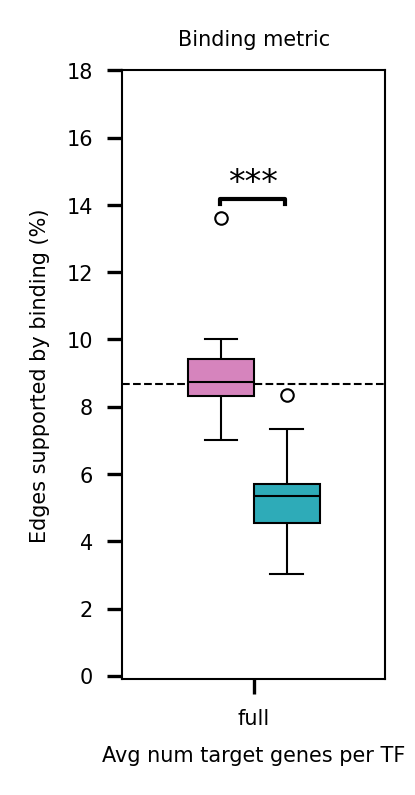

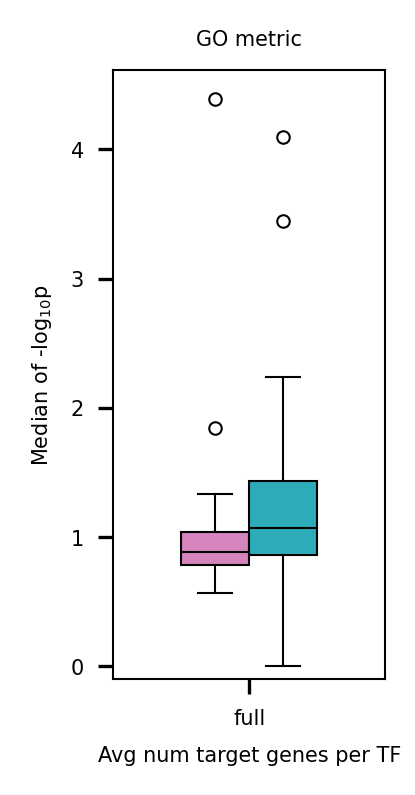

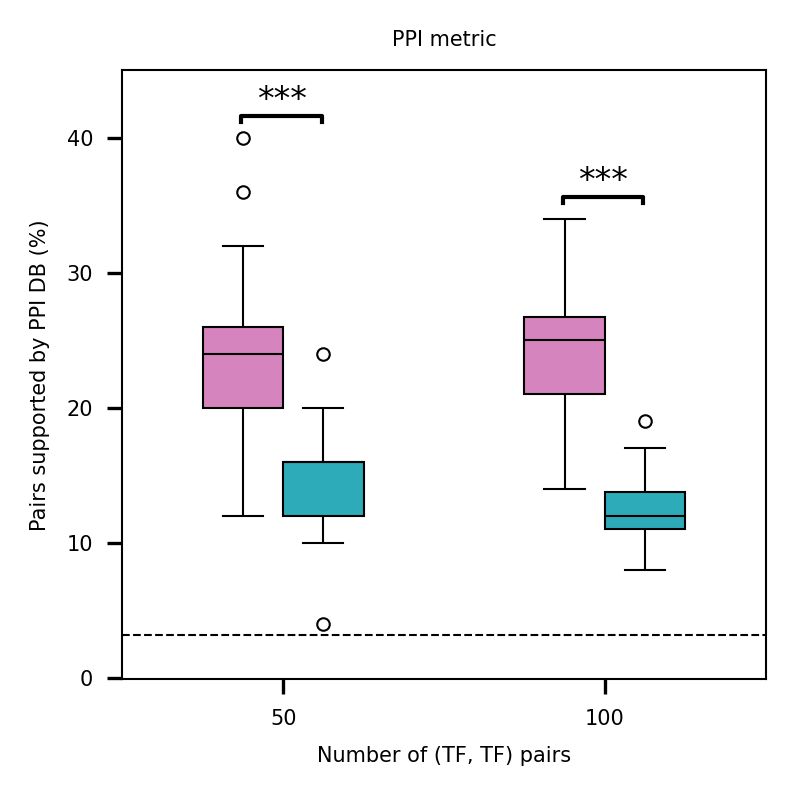

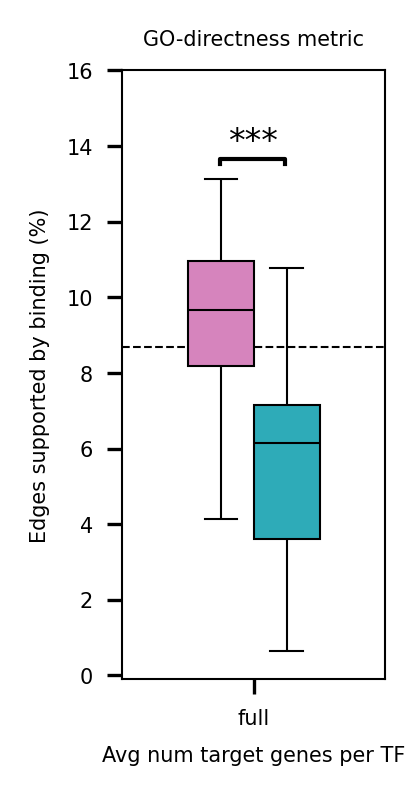

/ref/mblab/software/conda/envs/human_tf_project/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  fig.canvas.print_figure(bytes_io, **kw)


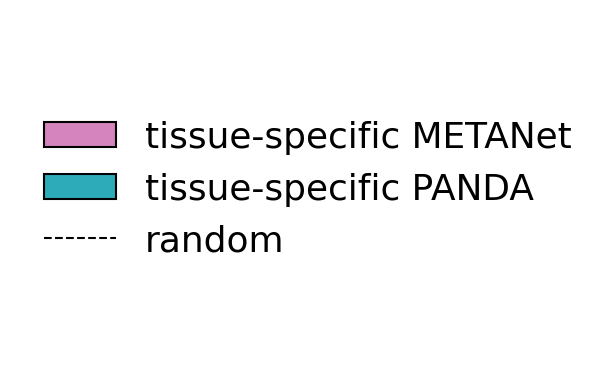

In [27]:
import matplotlib as mpl
import matplotlib.ticker as mticker

mpl.rcParams.update({
    # Use final physical size so text/lines are correct at submission size
    "figure.dpi": 300,          # affects rasterized bits only; OK to keep 300
    "savefig.dpi": 300,

    # Typography: readable at final size
    "font.family": "sans-serif",   # swap to Helvetica/Arial if you have them
    "font.size": 5,                  # axis/legend 8–9 pt; set per-artist as needed
    "axes.titlesize": 5,
    "axes.labelsize": 5,
    "xtick.labelsize": 5,
    "ytick.labelsize": 5,
    "legend.fontsize": 5,

    # Lines and markers
    "lines.linewidth": 0.5,     # in points; ≥0.5 pt per journal spec
    "axes.linewidth": 0.5,
    "grid.linewidth": 0.5,

    # Layout
    "figure.constrained_layout.use": True,  # better than tight_layout for panels
    "figure.autolayout": False,

    # Embed fonts as text (don’t outline)
    "pdf.fonttype": 42,         # TrueType
    "ps.fonttype": 42,
    "svg.fonttype": "none",     # keep text as <text>, not paths
})

W_FULL_inch = 170 / 25.4 # 170mm in inches
gutter_mm = 3
gutter_inch = gutter_mm / 25.4
panel_width_mm = (170 - (4 - 1) * gutter_mm)     # 4 panels with 3mm gutters
per_panel_mm = panel_width_mm / 5                # 4 panels, but PPI panel is twice the width of others
per_panel_inch = per_panel_mm / 25.4

flierprops = dict(marker='o', markersize=3,   # default ~6
                  linestyle='none', markeredgewidth=0.5)

## AX1 -- BINDING
fig1, ax1 = plt.subplots(figsize=(per_panel_inch,per_panel_inch*2), constrained_layout=True)
models_to_plot_binding = ['tissue-specific METANet','tissue-specific PANDA']
sns.boxplot(data = df_binding_final, x = 'rank', y = 'score', hue = 'model', hue_order=models_to_plot_binding, 
            palette=model_palette, width=0.5, zorder=100, legend=False, 
            flierprops=flierprops, 
            boxprops=dict(linewidth=0.5),
            whiskerprops=dict(linewidth=0.5),
            capprops=dict(linewidth=0.5),
            medianprops=dict(linewidth=0.5))
if args.plot_random:
    ax1.axhline(binding_random_expectation, ls='--', label='random', c='k')
xlim1 = ax1.get_xlim()
add_significance_bars_modified(ax1, dict_binding_ttest_final, df_binding_final, models_to_plot)
ax1.set_title(f"Binding metric")
ax1.set_ylabel("Edges supported by binding (%)")
ax1.set_xlabel("Avg num target genes per TF")
ax1.set_ylim(bottom=-0.1)
ax1.set_ylim(top=18)
ax1.set_xlim(xlim1)
ax1.yaxis.set_major_locator(mticker.MaxNLocator(integer=True))


## AX2 -- GO
fig2, ax2 = plt.subplots(figsize=(per_panel_inch,per_panel_inch*2), constrained_layout=True)
models_to_plot_go = ['tissue-specific METANet','tissue-specific PANDA']
sns.boxplot(data = df_go_final_random, x = 'rank', y = 'median', hue = 'model', hue_order=models_to_plot_go,
            palette=model_palette, width=0.5, zorder=100, legend=False, flierprops=flierprops, 
            boxprops=dict(linewidth=0.5),
            whiskerprops=dict(linewidth=0.5),
            capprops=dict(linewidth=0.5),
            medianprops=dict(linewidth=0.5))
xlim2 = ax2.get_xlim()
add_significance_bars_modified(ax2, dict_go_ttest_final_random, df_go_final_random, models_to_plot_go, score_col='median')
ax2.set_title(f"GO metric")
ax2.set_ylabel("Median of -$\mathrm{log}_{10}$p")
ax2.set_xlabel("Avg num target genes per TF")
ax2.set_ylim(bottom=-0.1)
ax2.set_xlim(xlim2)


## AX3 -- PPI
fig3, ax3 = plt.subplots(figsize=(per_panel_inch*2,per_panel_inch*2), constrained_layout=True)
models_to_plot_ppi = ['tissue-specific METANet','tissue-specific PANDA']
sns.boxplot(data = df_ppi_final, x = 'rank', y = 'ppi_support', hue = 'model', hue_order=models_to_plot_ppi,
            palette=model_palette, width=0.5, zorder=100, legend=False, flierprops=flierprops, 
            boxprops=dict(linewidth=0.5),
            whiskerprops=dict(linewidth=0.5),
            capprops=dict(linewidth=0.5),
            medianprops=dict(linewidth=0.5))
if args.plot_random:
    ax3.axhline(ppi_random_expectation, ls='--', label='random', c='k')
xlim3 = ax3.get_xlim()
add_significance_bars_modified(ax3, dict_ppi_ttest_final, df_ppi_final, models_to_plot_ppi, score_col='ppi_support')
ax3.set_title(f"PPI metric")
ax3.set_ylabel("Pairs supported by PPI DB (%)")
ax3.set_xlabel("Number of (TF, TF) pairs")
bottom, top = ax3.get_ylim()
# ax3.set_ylim(bottom, top+1)
ax3.set_ylim(bottom=-0.1, top=45)
ax3.set_xlim(xlim3)


## AX4 GO-DIRECTNESS
fig4, ax4 = plt.subplots(figsize=(per_panel_inch,per_panel_inch*2), constrained_layout=True)
models_to_plot_go_directness = ['tissue-specific METANet','tissue-specific PANDA']
sns.boxplot(data = df_go_directness_final_random, x = 'rank', y = 'score', hue = 'model', hue_order=models_to_plot_go_directness,
            palette=model_palette, width=0.5, zorder=100, legend=True, flierprops=flierprops, 
            boxprops=dict(linewidth=0.5),
            whiskerprops=dict(linewidth=0.5),
            capprops=dict(linewidth=0.5),
            medianprops=dict(linewidth=0.5))
ax4.axhline(binding_random_expectation, ls='--', label='random', c='k')
ax4.get_legend().set_title(None)
ax4.legend(fontsize='xx-large')
xlim4 = ax4.get_xlim()
add_significance_bars_modified(ax4, dict_go_directness_ttest_final_random, df_go_directness_final_random, models_to_plot_go_directness)
ax4.set_title(f"GO-directness metric")
ax4.set_ylabel("Edges supported by binding (%)")
ax4.set_xlabel("Avg num target genes per TF")
ax4.set_ylim(bottom=-0.1, top=16)
ax4.set_xlim(xlim4)


# save legend only
# pull legend artists from ax4
handles, labels = ax4.get_legend_handles_labels()

# make a new figure just for the legend
fig_leg = plt.figure(figsize=(per_panel_inch - gutter_inch, per_panel_inch - gutter_inch))
# create a single, empty Axes and turn the axis off
ax_leg = fig_leg.add_subplot(111)
ax_leg.axis('off')

# draw the legend centered in the new figure
leg = ax_leg.legend(handles, labels,
                    loc='center',
                    ncol=1,               # or more columns if you like
                    fontsize='xx-large',  # match your original fontsize
                    frameon=False)        # optional: turn off the legend frame


ax4.get_legend().remove()
plt.show()


### (i) imports, parameters, functions

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import argparse
import os

# pyplot parameters
plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams['axes.labelsize'] = 'xx-large'
plt.rcParams['xtick.labelsize'] = 'large'
plt.rcParams['ytick.labelsize'] = 'large'
plt.rcParams['legend.fontsize'] = 'large'
plt.rcParams['axes.titlesize'] = 'xx-large'
plt.rcParams['figure.titlesize'] = 'xx-large'
plt.rcParams['figure.labelsize'] = 'xx-large'

# MODEL PLOTTING COLOR SCHEME #
model_palette = {
    'panda_tissue_specific':'tab:cyan',
    'metanet_tissue_specific':'tab:pink',
    'tissue-specific PANDA':'tab:cyan',
    'tissue-specific METANets':'tab:pink'
}


# paths
tissues_path = "/scratch/mblab/jungw/human_TF_project/data/xgboost_all_gtex_tissues/tissues_panda_metanet_overlap.txt"
eqtl_eval_path = "/scratch/mblab/jungw/human_TF_project/data/xgboost_all_gtex_tissues/eval_tissue_specificity/"
output_path = "/scratch/mblab/jungw/human_TF_project/manuscript_figures/tissue_specificity/"

# functions
def load_eqtl(tissues, eqtl_path, model):
    df_list  = []
    for tissue in tissues: # load
        df = pd.read_csv(os.path.join(eqtl_path, f"results_{model}_original_eqtl/", "final_output_per_human_network_tissue_aggregated/", f"{tissue}.tsv"), sep="\t")
        df_list.append(df)
    df = pd.concat(df_list)

    # subset for eqtl tissues
    df = df[df['eqtl_tissue'].isin(tissues)]
    # subset for network tissues
    df = df[df['network_tissue'].isin(tissues)]
    return df

def calculate_ranks(df):
    
    df['eqtl_supp_rank'] = df.groupby(['eqtl_tissue','rank'])['eqtl_supp'].rank(ascending=False, method='dense')
    df['eqtl_counts_rank'] = df.groupby(['eqtl_tissue','rank'])['eqtl_counts'].rank(ascending=False, method='dense')

    # break ties by using the other metric
    df = df.sort_values(by='eqtl_counts', ascending=False)
    df['eqtl_supp_rank_break_ties'] = df.groupby(['eqtl_tissue','rank'])['eqtl_supp'].rank(ascending=False, method='first')
    df = df.sort_values(by='eqtl_supp', ascending=False)
    df['eqtl_counts_rank_break_ties'] = df.groupby(['eqtl_tissue','rank'])['eqtl_counts'].rank(ascending=False, method='first')

    return df

def permutation_test(df, thresholds=['50','100','250','full'], n_permutations=10000, seed=42):

    def _permutation_test(df, threshold, n_permutations, seed=42, eqtl_metric='supp'):

        df = df[df['rank'] == threshold]
        df = df[['eqtl_tissue','network_tissue',f'eqtl_{eqtl_metric}_rank_break_ties']]
        df = df.pivot(index=['eqtl_tissue'], columns=['network_tissue'])
        
        data = df.to_numpy()
        n = data.shape[0]
    
        # 1. observed diagonal sum
        observed_sum = np.sum(np.diag(data))
    
        # 2. generate permutations and compute sums
        rng = np.random.default_rng(42)
        perm_sums = np.zeros(n_permutations, dtype=float)
    
        for k in range(n_permutations):
            # create random permutation of column indices
            perm = rng.permutation(n)
            # sum
            perm_sum = 0
            for row in range(n):
                perm_sum += data[row, perm[row]]
            perm_sums[k] = perm_sum
    
        # 3. compute one-sided p-value
        p_value = np.mean(perm_sums <= observed_sum)
        return observed_sum, perm_sums, p_value

    dict_res = {}
    for threshold in thresholds:
        print(threshold)
        res_supp = _permutation_test(df, threshold, n_permutations, seed, eqtl_metric='supp')
        res_counts = _permutation_test(df, threshold, n_permutations, seed, eqtl_metric='counts')
        dict_res[threshold] = {}
        dict_res[threshold]['eQTL support'] = res_supp
        dict_res[threshold]['eQTL counts'] = res_counts
    return dict_res

### (ii) load data

In [ ]:
# load tissues
tissues = np.loadtxt(tissues_path, dtype=str)

# load eqtl results
df_metanet_tissue_specific = load_eqtl(tissues, eqtl_eval_path, 'metanet_tissue_specific')
df_panda_tissue_specific = load_eqtl(tissues, eqtl_eval_path, 'panda_tissue_specific')

### (iii) evaluation result processing

#### calculate ranks

In [ ]:
# calculate ranks
df_metanet_tissue_specific = calculate_ranks(df_metanet_tissue_specific)
df_panda_tissue_specific = calculate_ranks(df_panda_tissue_specific)

# annotate
df_metanet_tissue_specific['model'] = 'tissue-specific METANets'
df_panda_tissue_specific['model'] = 'tissue-specific PANDA'

#### run permutation test

In [ ]:
df_metanet_tissue_specific_permutation = permutation_test(df_metanet_tissue_specific, thresholds=['full'])
df_panda_tissue_specific_permutation = permutation_test(df_panda_tissue_specific, thresholds=['full'])

In [ ]:
df_metanet_tissue_specific_permutation

In [ ]:
df_panda_tissue_specific_permutation

### (iv) PLOT -- PERMUTATION ANALYSIS 

#### empirical distribution

In [ ]:
def plot_permutation(dict_final, dict_marbach, eqtl_metric='eQTL support'):
    fig, axes = plt.subplots(2,1, figsize=(13,10), sharey=True, sharex=False, constrained_layout=True)
    for i,threshold in enumerate(dict_final.keys()):
    
        ax_final = axes[0]
        ax_marbach = axes[1]
    
        obs_final, perm_final, p_final = dict_final[threshold][eqtl_metric]
        obs_marbach, perm_marbach, p_marbach = dict_marbach[threshold][eqtl_metric]

        assert len(perm_final) == len(perm_marbach)
        n_permutations = len(perm_final)
    
        sns.histplot(perm_final, bins=50, label='Permutation', color=model_palette['metanet_tissue_specific'], ax=ax_final)
        ax_final.axvline(obs_final, color='black', linestyle='--', lw=1.5, label='Observed')
        if i == 0:
            ax_final.legend()
        title = f"Avg {threshold} targets per TF\n"
        if p_final < 0.05:
            title = title + r"$\bf{{p={:.4f}}}$".format(p_final)
        else:
            title = title + "p={:.4f}".format(p_final)
            
        ax_final.set_title(title)
        ax_final.set_ylabel("tissue-specific METANets")
        
        sns.histplot(perm_marbach, bins=50, label='permutation', color=model_palette['panda_tissue_specific'], ax=ax_marbach)
        ax_marbach.axvline(obs_marbach, color='black', linestyle='--', lw=1.5, label='Observed')
        if i == 0:
            ax_marbach.legend()
        if p_marbach < 0.05:
            title = r"$\bf{{p={:.4f}}}$".format(p_marbach)
        else:
            title = "p={:.4f}".format(p_marbach)
        
        ax_marbach.set_title(title)
        ax_marbach.set_ylabel("tissue-specific PANDA")
    
    plt.suptitle(f"Observed Sum of {eqtl_metric} Ranks vs {n_permutations} Permutations")
    fig.supxlabel(f"Sum of Ranks")
    eqtl_metric_nospace = eqtl_metric.replace(' ', '_')
    plt.savefig(os.path.join(output_path, f"metanet_panda_tissue_specific_{eqtl_metric_nospace}_vs_permutation.svg"), format='svg', bbox_inches='tight', dpi=600)
    plt.show()
    
plot_permutation(df_metanet_tissue_specific_permutation, df_panda_tissue_specific_permutation, eqtl_metric='eQTL support')
plot_permutation(df_metanet_tissue_specific_permutation, df_panda_tissue_specific_permutation, eqtl_metric='eQTL counts')


### (v) PLOT -- METANETS VS PANDA

#### Wilcoxon Signed Rank Test

In [ ]:
from scipy.stats import wilcoxon
import itertools

def wilcoxon_test(df_final, df_marbach, threshold='full', eqtl_metric='eqtl_supp'):

    df_final = df_final[df_final['rank'] == threshold]
    df_marbach = df_marbach[df_marbach['rank'] == threshold]

    df_final = df_final[df_final['eqtl_tissue'] == df_final['network_tissue']]
    df_marbach = df_marbach[df_marbach['eqtl_tissue'] == df_marbach['network_tissue']]

    df_final = df_final.sort_values(by='eqtl_tissue')
    df_marbach = df_marbach.sort_values(by='eqtl_tissue')

    x = df_final[f'{eqtl_metric}_rank_break_ties']
    y = df_marbach[f'{eqtl_metric}_rank_break_ties']

    # print(df_final)
    # print(df_marbach)
    df_plot = pd.concat([df_final, df_marbach])
    sns.boxplot(df_plot, x='rank', y=f'{eqtl_metric}_rank_break_ties', hue='model', palette=model_palette)
    plt.title(f"Distribution of matching tissue ranks\n{eqtl_metric}")
    plt.ylim(0,34)
    plt.legend(loc=0)
    plt.ylabel(None)
    plt.xlabel(None)
    plt.tick_params(
        axis='x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom=False,      # ticks along the bottom edge are off
        top=False,         # ticks along the top edge are off
        labelbottom=False # labels along the bottom edge are off
    )
    plt.savefig(os.path.join(output_path, f"metanet_panda_tissue_specific_{eqtl_metric}_boxplot.svg"), format='svg', bbox_inches='tight', dpi=600)
    plt.show()

    print(x)
    print(y)
    w, p_two =  wilcoxon(x,y, method='exact', alternative='two-sided')
    diff = np.array(x) - np.array(y)
    print(diff)
    print(np.median(diff))
    print(sum(diff < 0))
    print(sum(diff == 0))
    print(sum(diff > 0))
    
    return w, p_two

w_list = []
p_two_list = []
rank_list = []
eqtl_list = []
for threshold, eqtl_metric in itertools.product(['full'], ['eqtl_supp','eqtl_counts']):
    w, p_two = wilcoxon_test(df_metanet_tissue_specific, df_panda_tissue_specific, threshold=threshold, eqtl_metric=eqtl_metric)
    rank_list.append(threshold)
    eqtl_list.append(eqtl_metric)
    w_list.append(w)
    p_two_list.append(p_two)
df_table = pd.DataFrame({'Avg targets per TF':rank_list, 'eQTL metric': eqtl_list, 'Wilcoxon w': w_list, 'Wilcoxon p (two-sided)':p_two_list})
# df_table.to_csv(os.path.join(output_path, f"metanet_panda_tissue_specific_wilcoxon_signed_rank_test.tsv"), sep="\t", index=False)
df_table

#### RAW eQTL results

In [ ]:
fig, axes = plt.subplots(1,2, figsize=(10,5))

sns.boxplot(df_plot, x = 'rank', y = 'eqtl_supp', hue='model', ax=axes[0], legend=False, palette=model_palette)
axes[0].set_ylim(-0.25,2)
axes[0].set_yticks(np.arange(0,2.5,0.5))
axes[0].set_xlabel(None)
axes[0].set_ylabel("eQTL support")
# axes[0].plot([-0.2,-0.2,0.2,0.2], [1.65, 1.7, 1.7, 1.65], lw=1.5, c='black')
# axes[0].text(0, 1.7, round(mannwhitneyu_p_dict[50]['eqtl_supp'],3), ha='center', va='bottom', fontsize=10)

sns.boxplot(df_plot, x = 'rank', y = 'eqtl_counts', hue='model', ax=axes[1], palette=model_palette)
axes[1].legend(title=None)
axes[1].set_ylim(-500,5100)
axes[1].yaxis.set_label_position("right")
axes[1].yaxis.tick_right()
axes[1].set_ylabel("eQTL counts")
axes[1].set_xlabel(None)
axes[1].plot([-0.2,-0.2,0.2,0.2], [3500, 3600, 3600, 3500], lw=1.5, c='black')
axes[1].text(0, 3600, round(mannwhitneyu_p_dict['full']['eqtl_counts'],4), ha='center', va='bottom', fontsize=10)


fig.suptitle("eQTL evaluation distributions")
fig.supxlabel("Avg number of targets per TF")
plt.savefig(os.path.join(output_path, "eQTL_metanets_vs_panda_tissue_specifi_distributions.svg"),
            format="svg", bbox_inches="tight", dpi=600)
plt.show()

In [ ]:
df_table.pivot(columns='Avg targets per TF', index='eQTL metric', values='Wilcoxon w')

In [ ]:
df_table.pivot(columns='Avg targets per TF', index='eQTL metric', values='Wilcoxon p (two-sided)')